In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import glob, functools, tqdm, PIL
from multiprocess import Pool

def imread(fn):
    return np.array(PIL.Image.open(fn))

def imsize(fn):
    im = PIL.Image.open(fn)
    sz = im.size
    im.close()
    return sz

def is_landscape(fn): #landscape or portrait
    s = imsize(fn)
    return s[0] > s[1]

In [2]:
train = pd.DataFrame({'path':glob.glob('/home/mashrin/input/train/*/*')})
train['modelname'] = train.path.map(lambda p:p.split('/')[-2])

In [3]:
import cv2

def random_crop_fft(img, W):
    nr, nc = img.shape[:2]
    r1, c1 = np.random.randint(nr-W), np.random.randint(nc-W) 
    imgc = img[r1:r1+W, c1:c1+W, :]

    img1 = imgc - cv2.GaussianBlur(imgc, (3,3), 0)
    imgs1 = np.sum(img1, axis=2)
    
    sf = np.stack([
         np.fft.fftshift(np.fft.fft2( imgs1 )),
         np.fft.fftshift(np.fft.fft2( img1[:,:,0] - img1[:,:,1] )),
         np.fft.fftshift(np.fft.fft2( img1[:,:,1] - img1[:,:,2] )),
         np.fft.fftshift(np.fft.fft2( img1[:,:,2] - img1[:,:,0] )) ], axis=-1)
    return np.abs(sf)
    
def imread_residual_fft(fn, W, navg):
    #print(fn, rss())
    img = imread(fn).astype(np.float32) / 255.0
    return sum(map(lambda x:random_crop_fft(img, W), range(navg))) / navg

def noise_pattern(modelname, W, navg=256):
    files = train.path[train.modelname == modelname].values
    orientations = np.vectorize(is_landscape)(files)
    if np.sum(orientations) < len(orientations)//2:
        orientations = ~orientations
    files = files[orientations]

    from multiprocess import Pool
    with Pool() as pool:
        s = sum(tqdm.tqdm(pool.imap(lambda fn:imread_residual_fft(fn, W, navg), files), total=len(files), desc=modelname)) / len(files)
    
    return s

In [4]:
def plot_model_features(modelname, W):
    s = noise_pattern(modelname, W)
    nchans = s.shape[2]
    nrows = (nchans + 3) // 4
    _, ax = plt.subplots(nrows, 4, figsize=(16, 4 * nrows))
    ax = ax.flatten()

    for c in range(nchans):
        eps = np.max(s[:,:,c]) * 1e-2
        s1 = np.log(s[:,:,c] + eps) - np.log(eps) 
        img = (s1 * 255 / np.max(s1)).astype(np.uint8)
        ax[c].imshow(cv2.equalizeHist(img))
        
    for ax1 in ax[nchans:]:
        ax1.axis('off')

    plt.show()
    
def plot_all_model_features(W):
    print("Feature Size={}".format(W))
    for modelname in train.modelname.unique():
        plot_model_features(modelname, W)

Feature Size=128


HTC-1-M7: 100%|██████████| 254/254 [01:46<00:00,  2.39it/s]


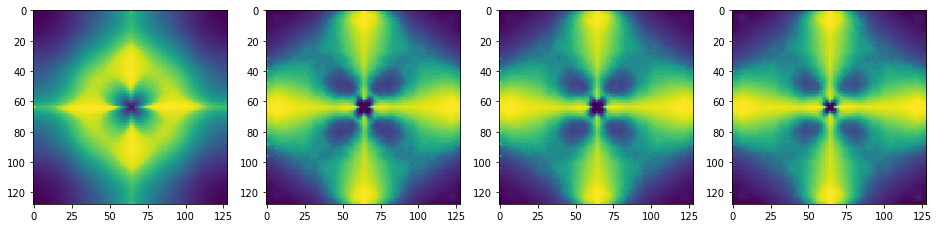

Motorola-Nexus-6: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


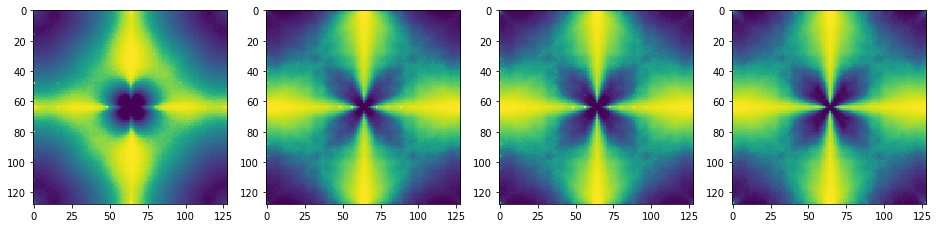

Sony-NEX-7: 100%|██████████| 275/275 [03:13<00:00,  1.42it/s]


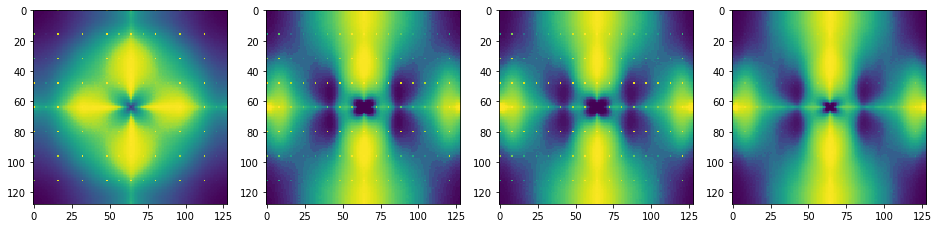

Samsung-Galaxy-S4: 100%|██████████| 275/275 [02:25<00:00,  1.89it/s]


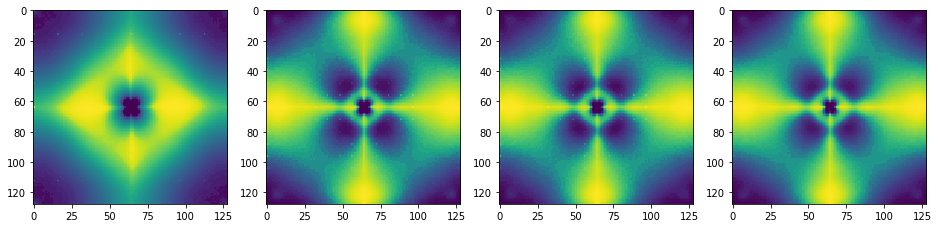

iPhone-6: 100%|██████████| 275/275 [02:44<00:00,  1.67it/s]


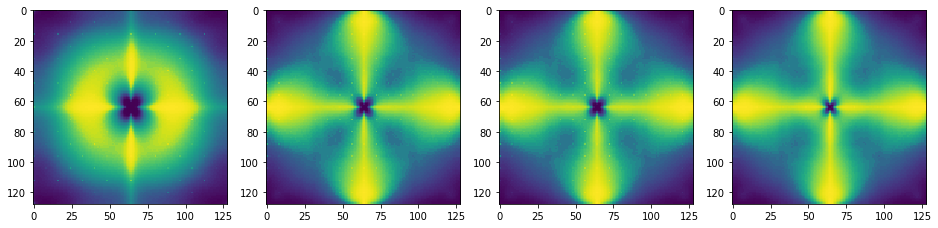

iPhone-4s: 100%|██████████| 275/275 [02:03<00:00,  2.22it/s]


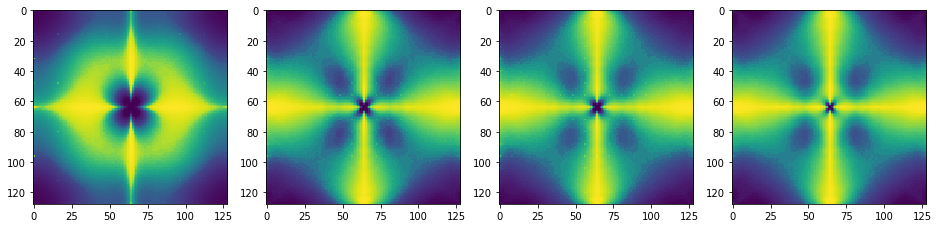

Motorola-X: 100%|██████████| 234/234 [02:03<00:00,  1.89it/s]


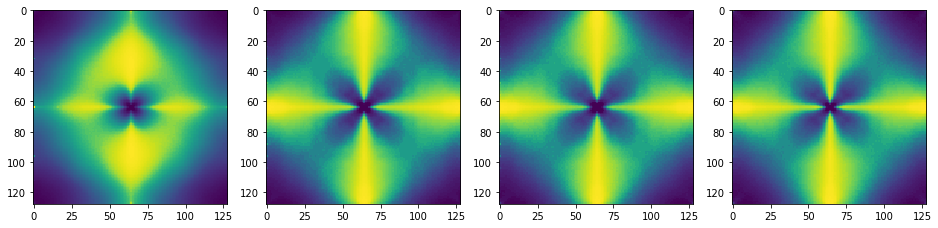

Motorola-Droid-Maxx: 100%|██████████| 236/236 [01:51<00:00,  2.11it/s]


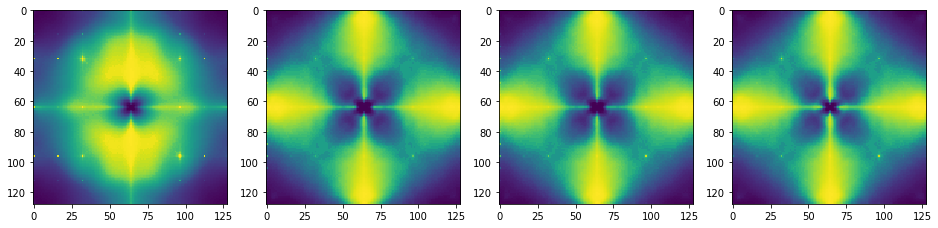

Samsung-Galaxy-Note3: 100%|██████████| 275/275 [02:03<00:00,  2.22it/s]


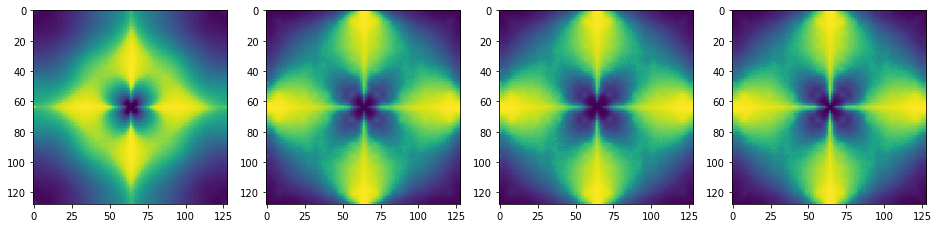

LG-Nexus-5x: 100%|██████████| 272/272 [02:14<00:00,  2.02it/s]


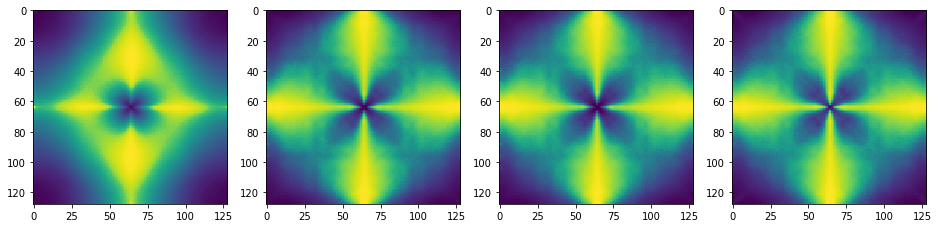

In [5]:
plot_all_model_features(W=128)